<a href="https://colab.research.google.com/github/idebroy/ml-ds/blob/main/k_house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [148]:
# prompt: write a function to load a csv file from google drive
def load_csv_from_drive(file_path):
  """Loads a CSV file from Google Drive into a pandas DataFrame.

  Args:
    file_path: The path to the CSV file on Google Drive.

  Returns:
    A pandas DataFrame containing the data from the CSV file.
  """
  drive.mount('/content/drive', force_remount=True)

  try:
    df = pd.read_csv(file_path)
    return df
  except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    return None
  except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    return None

# Example usage:
# Assuming your CSV file is located at '/content/drive/My Drive/my_data.csv'
trainFilePath = '/content/drive/My Drive/Colab-Stuff/kaggle/train.csv'
df = load_csv_from_drive(trainFilePath)
print(f"Drive \"connected to:\" {trainFilePath}")

testFilePath = '/content/drive/My Drive/Colab-Stuff/kaggle/test.csv'
df_test = load_csv_from_drive(testFilePath)
print(f"Drive \"connected to:\" {testFilePath}")

# If the file is loaded successfully, you can work with the DataFrame 'df'.
# For example, you can print the first few rows:
print(df.info())

Mounted at /content/drive
Drive "connected to:" /content/drive/My Drive/Colab-Stuff/kaggle/train.csv
Mounted at /content/drive
Drive "connected to:" /content/drive/My Drive/Colab-Stuff/kaggle/test.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-nul

In [149]:
def impute_categorical_nan(data, column):
  """
  Imputes missing values in a categorical column with the most frequent value.

  Args:
    data: Pandas DataFrame.
    column: Name of the categorical column with missing values.

  Returns:
    Pandas DataFrame with imputed values.
  """

  # Find the most frequent value
  most_frequent_value = data[column].mode()[0]
  print(most_frequent_value)

  # Fill missing values with the most frequent value
  data[column] = data[column].fillna(most_frequent_value)

  return data

def impute_numerical_nan(data, column):
  """
  Imputes missing values in a numerical column with the mean.
  Args:
    data: Pandas DataFrame.
    column: Name of the numerical column with missing values.
  Returns:
    Pandas DataFrame with imputed values.
  """
  # Calculate the mean
  mean = data[column].mean()

  # Fill missing values with the mean
  data[column] = data[column].fillna(mean)

  return data

def impute_nan(data, column):
  """
  Imputes missing values in a column based on its data type.

  Args:
    data: Pandas DataFrame.
    column: Name of the column with missing values.

  Returns:
    Pandas DataFrame with imputed values.
  """
  if column in data.select_dtypes(include=['number']).columns:
    data = impute_numerical_nan(data, column)
  else:
    data = impute_categorical_nan(data, column)

  return data

def find_cat_correlation(data, cat_cols, target_col):
  """
  Finds the categorical column most highly correlated (using Cramér's V) with the target column.

  Args:
      data: Pandas DataFrame.
      cat_cols: List of categorical columns.
      target_col: Name of the target column (must be categorical).

  Returns:
      Name of the most highly correlated categorical column.
  """
  from scipy.stats import chi2_contingency

  correlations = {}

  for col in cat_cols:
    if col != target_col:
      contingency_table = data.pivot_table(index=target_col, columns=col, aggfunc='size', fill_value=0)
      chi2, _, _, _ = chi2_contingency(contingency_table)
      n = contingency_table.sum().sum()
      phi2 = chi2 / n
      min_dim = min(contingency_table.shape) - 1
      cramers_v = np.sqrt(phi2 / min_dim)
      correlations[col] = cramers_v

  most_correlated_column = max(correlations, key=correlations.get)
  return most_correlated_column

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [144]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


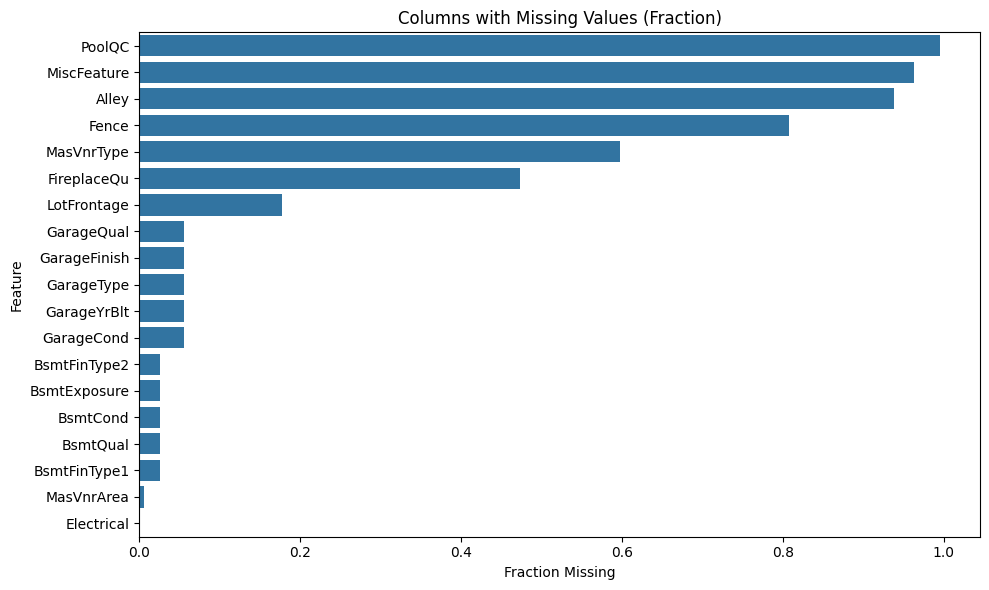

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Columns with missing values, in percentage
missing_pct = df.isnull().mean().sort_values(ascending=False)

# 2. Columns with only one unique value
one_value_cols = [col for col in df.columns if df[col].nunique() == 1]

# 3. Print top columns with highest missing
missing_pct.head(15), one_value_cols


plt.figure(figsize=(10, 6))
sns.barplot(y=missing_pct[missing_pct > 0].index, x=missing_pct[missing_pct > 0].values)
plt.title('Columns with Missing Values (Fraction)')
plt.xlabel('Fraction Missing')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

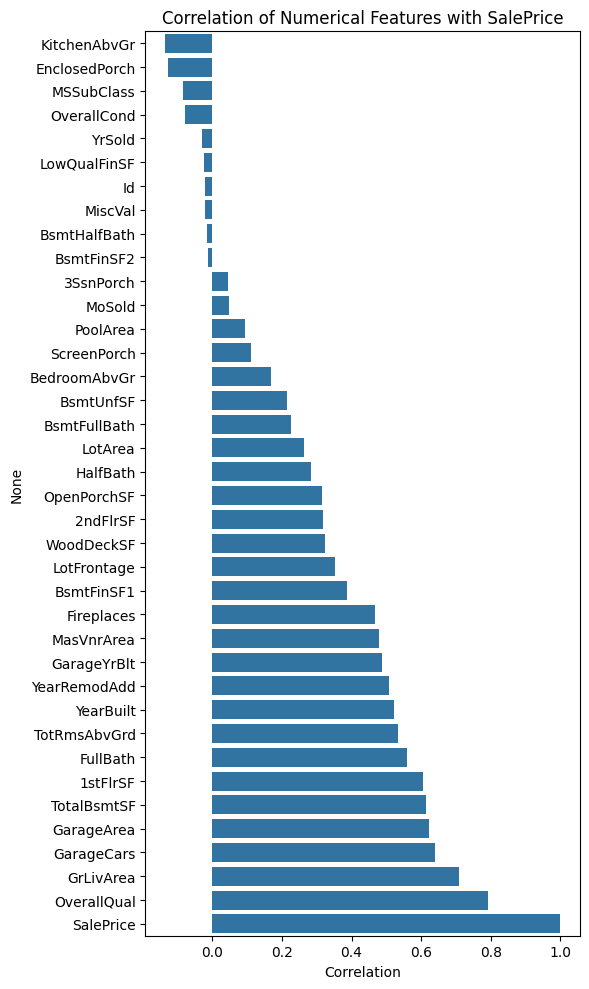

,SalePrice
KitchenAbvGr,-0.135907
EnclosedPorch,-0.128578
MSSubClass,-0.084284
OverallCond,-0.077856
YrSold,-0.028923
LowQualFinSF,-0.025606
Id,-0.021917
MiscVal,-0.021190
BsmtHalfBath,-0.016844
BsmtFinSF2,-0.011378


In [53]:
# Correlation matrix for numerical features only
numerical = df.select_dtypes(include=['int64', 'float64'])
corr_with_target = numerical.corr()['SalePrice'].sort_values()

# Plot the lowest and highest correlations with SalePrice
plt.figure(figsize=(6, 10))
sns.barplot(y=corr_with_target.index, x=corr_with_target.values)
plt.title('Correlation of Numerical Features with SalePrice')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

# Show weakly/negatively correlated features
corr_with_target.head(10)


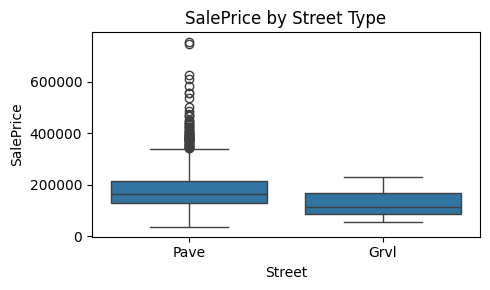

,count
Street,
Pave,1454
Grvl,6


In [54]:
plt.figure(figsize=(5,3))
sns.boxplot(x="Street", y="SalePrice", data=df)
plt.title("SalePrice by Street Type")
plt.tight_layout()
plt.show()

# Check unique values for 'Street'
df['Street'].value_counts()


**Which Features to Drop**
Based on the above analysis, you can consider dropping:
ID column:

   Id (just an identifier)

Columns with >80% missing:

  PoolQC
  MiscFeature
  Alley
  Fence

Features with little variance:

Street (almost all "Pave")

Other similar columns after inspecting their value counts (e.g., Utilities if almost all same value)

Features with very weak correlation to SalePrice:

MiscVal, LowQualFinSF, etc.


In [150]:
# List of columns to drop based on previous audit
cols_to_drop = ['Id',         # Identifier
    'PoolQC',     # >99% missing
    'MiscFeature',# >96% missing
    'Alley',      # >93% missing
    'Fence',      # >80% missing
    'Street',     # Almost all same value
    'LotFrontage', # LotFrontage is numerical, better to impute
    'GarageYrBlt','MSZoning_RH', 'LotShape_IR3', 'Neighborhood_Blueste', 'Neighborhood_SawyerW', 'Condition2_Feedr', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_SFoyer', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'RoofMatl_Membran', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_CBlock', 'Exterior1st_MetalSd', 'Exterior1st_Stone', 'Exterior2nd_AsphShn', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_Stucco', 'ExterCond_Po', 'ExterCond_TA', 'BsmtFinType1_Unf', 'BsmtFinType2_Unf', 'Heating_GasW', 'HeatingQC_Po', 'Electrical_FuseP', 'Electrical_Mix', 'FireplaceQu_Gd', 'GarageCond_Gd', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth']
#  [
#     'Id',         # Identifier
#     'PoolQC',     # >99% missing
#     'MiscFeature',# >96% missing
#     'Alley',      # >93% missing
#     'Fence',      # >80% missing
#     'Street',     # Almost all same value
#     'LotFrontage', # LotFrontage is numerical, better to impute
#     'GarageYrBlt',
#     # Add any others you identify (e.g. 'Utilities', 'MiscVal', etc. if analysis shows)
# ]

# Actually drop those columns if they exist
df_cleaned = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
## df_test = df_test.drop(columns=[col for col in cols_to_drop if col in df_test.columns])


# Impute remaining missing values
for col in df_cleaned.columns:
  if df_cleaned[col].isnull().any():
    df_cleaned = impute_nan(df_cleaned, col)


# Confirm removal and imputation
print("Remaining columns after drop:", df_cleaned.columns.tolist())
print("Shape of cleaned dataframe:", df_cleaned.shape)
print(f"nan in train df : {df_cleaned.isna().sum().sum()}")

BrkFace
TA
TA
No
Unf
Unf
SBrkr
Gd
Attchd
Unf
TA
TA
Remaining columns after drop: ['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPo

## Visualize Correlation with SalePrice
Let’s check which numerical features are most/least correlated with the target.

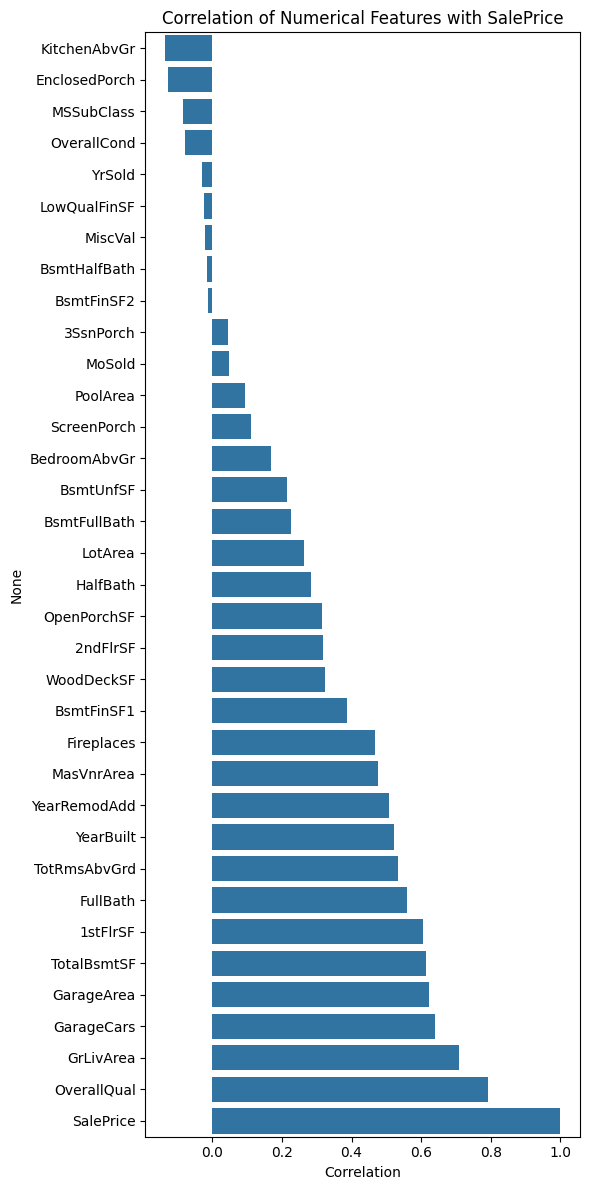

In [151]:
# Only numerical features
numerical = df_cleaned.select_dtypes(include=['int64', 'float64'])

# Correlation with SalePrice
corr_with_target = numerical.corr()['SalePrice'].sort_values()

plt.figure(figsize=(6, 12))
sns.barplot(y=corr_with_target.index, x=corr_with_target.values)
plt.title('Correlation of Numerical Features with SalePrice')
plt.xlabel('Correlation')
plt.tight_layout()
plt.show()

## Visualize Categorical Features
Examine the relationship between important categorical features and the target variable:

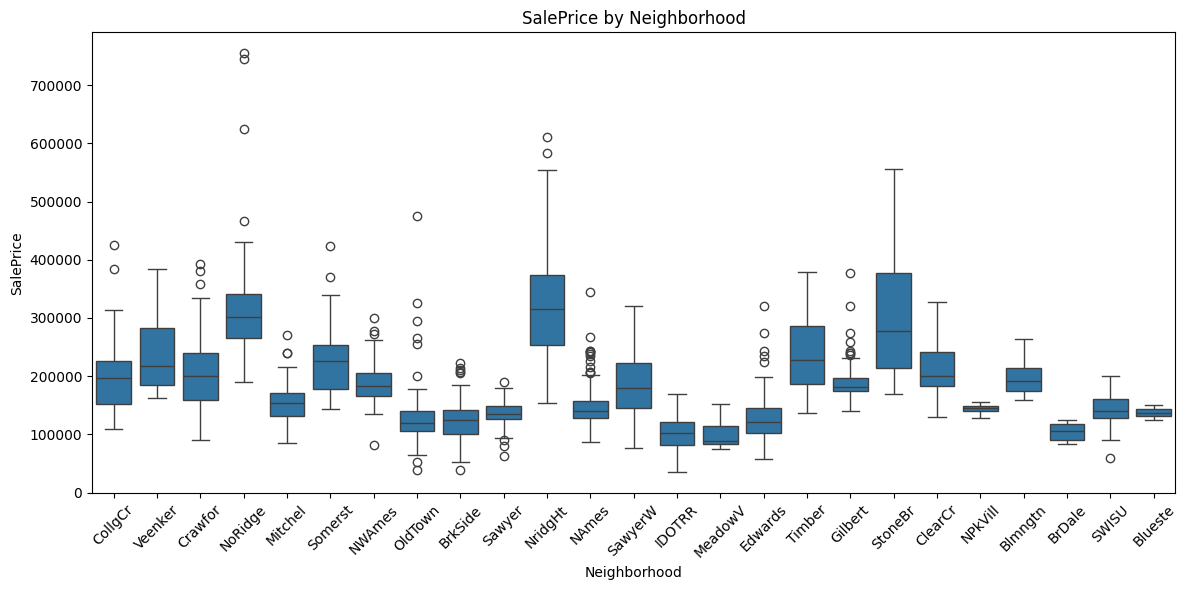

In [152]:
# Example: Neighborhood vs. SalePrice
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_cleaned)
plt.xticks(rotation=45)
plt.title("SalePrice by Neighborhood")
plt.tight_layout()
plt.show()


## Feature Importance with a Simple Model
Fit a random forest to quickly get a sense of feature importances (numeric + one-hot categorical)

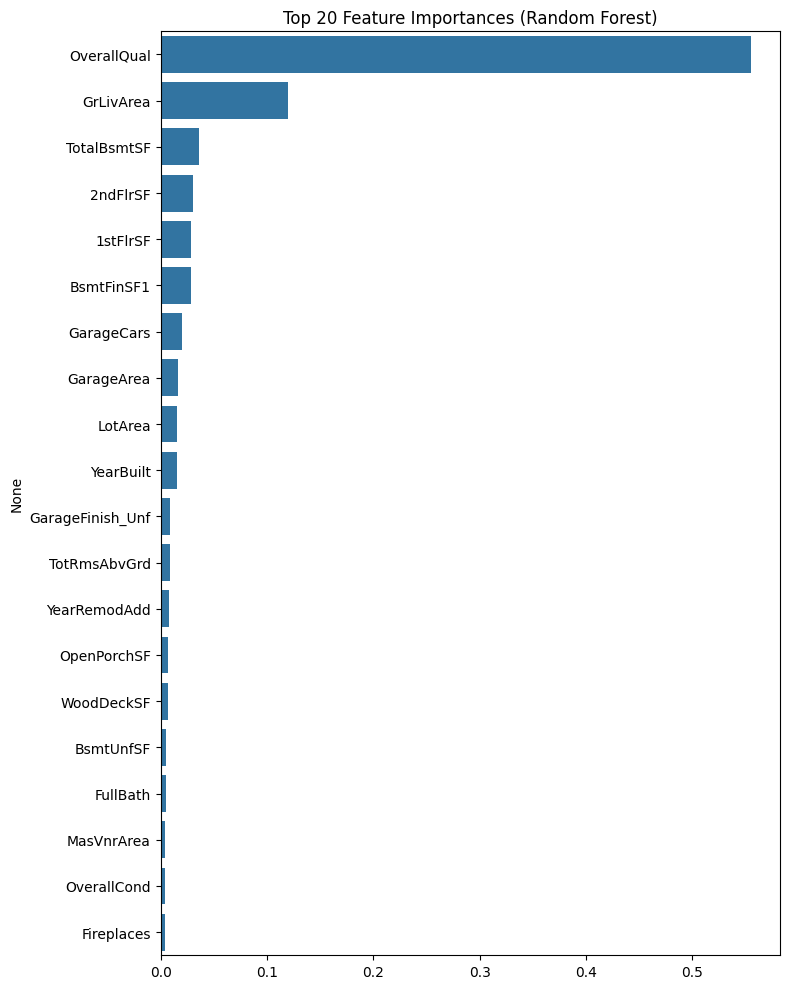

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare data (simple encoding of categoricals)
df_model = pd.get_dummies(df_cleaned, drop_first=True)
X = df_model.drop('SalePrice', axis=1)
y = df_model['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Train random forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 10))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

## load test.csv
For testing model performance

In [154]:
from sklearn.linear_model import LinearRegression

df_model = pd.get_dummies(df_cleaned, drop_first=True)
X = df_model.drop('SalePrice', axis=1)
y = df_model['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

lr = LinearRegression()
lr.fit(X, y)

# Predict on the test set
y_pred = lr.predict(X_test)

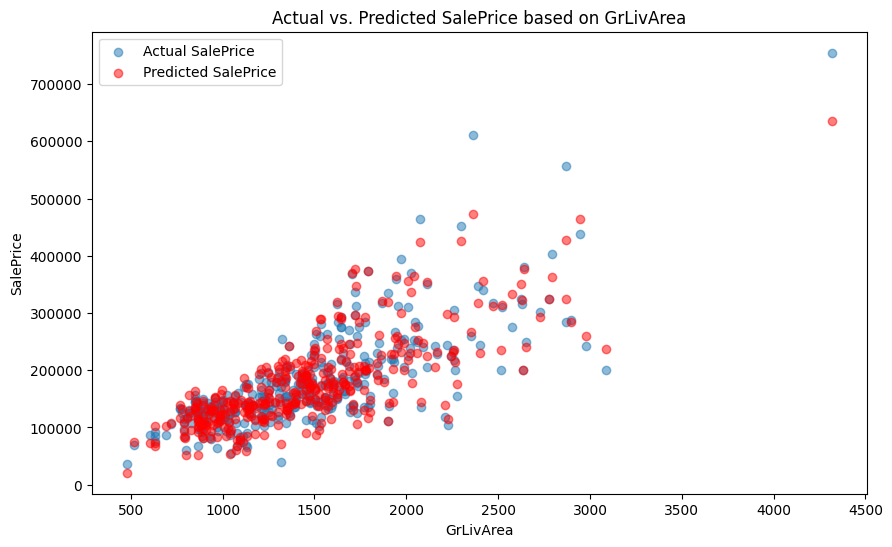

In [156]:
# prompt: Add a scatter plot to show the original points and a line of y_pred

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(X_test['GrLivArea'], y_test, alpha=0.5, label='Actual SalePrice')
plt.scatter(X_test['GrLivArea'], y_pred, alpha=0.5, color='red', label='Predicted SalePrice')
plt.xlabel('GrLivArea') # Or any other relevant feature from X_test
plt.ylabel('SalePrice')
plt.title('Actual vs. Predicted SalePrice based on GrLivArea')
plt.legend()
plt.show()

## Evaluate Model performance

In [155]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared: {r2:.3f}")


Root Mean Squared Error (RMSE): 21474.14
R-squared: 0.934


## Cross Validation

In [135]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Assume X_train, y_train from previous steps
lr = LinearRegression()

# 5-fold cross-validation (using negative MSE for scoring, convert to RMSE)
neg_mse_scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-neg_mse_scores)

print("Cross-validated RMSEs:", rmse_scores)
print("Mean cross-validated RMSE:", rmse_scores.mean())


Cross-validated RMSEs: [30008.49242186 63122.8397949  40872.26471401 27891.13680854
 55824.91676108]
Mean cross-validated RMSE: 43543.930100076715


## Grid Search with Ridge Regression

In [136]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define Ridge regression and hyperparameter grid
ridge = Ridge()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 200, 500]}

# Grid search with 5-fold cross-validation
grid = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

# Best alpha and corresponding cross-validated RMSE
best_alpha = grid.best_params_['alpha']
best_rmse = np.sqrt(-grid.best_score_)

print("Best alpha (regularization):", best_alpha)
print("Best cross-validated RMSE:", best_rmse)


Best alpha (regularization): 10
Best cross-validated RMSE: 38916.428050920775


## Lasso feature engg


In [139]:
from sklearn.linear_model import Lasso
# Fit Lasso with best alpha
best_lasso = Lasso(alpha=best_alpha, max_iter=10000)
best_lasso.fit(X_train, y_train)

# Get coefficients and feature names
coefs = best_lasso.coef_
feature_names = X_train.columns

# Identify selected (non-zero) and eliminated (zero) features
selected_features = feature_names[coefs != 0]
eliminated_features = feature_names[coefs == 0]

print("Selected (non-zero) features:\n", selected_features.tolist())
print("\nEliminated (zero) features:\n", eliminated_features.tolist())


Selected (non-zero) features:
 ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR2', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel

## Predict for test data

In [147]:
# prompt: Need to predict the result for the df_test now, with format id vs SalePrice

import pandas as pd
# Ensure the test dataframe has the same columns as the training dataframe after one-hot encoding
# This is crucial for the model to make predictions
df_test_model = pd.get_dummies(df_test, drop_first=True)

# Align columns - add missing columns present in training data and fill with 0, remove extra columns
train_cols = X.columns
test_cols = df_test_model.columns

missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    df_test_model[c] = 0

extra_in_test = set(test_cols) - set(train_cols)
for c in extra_in_test:
    df_test_model = df_test_model.drop(c, axis=1)

# Ensure the order of columns is the same
df_test_model = df_test_model[train_cols]

# Impute remaining missing values in df_test_model
for col in df_test_model.columns:
  if df_test_model[col].isnull().any():
    df_test_model = impute_nan(df_test_model, col)


print(df_test_model.isnull().sum()[df_test_model.isnull().sum() > 0])


# Predict on the (processed) test dataset
test_predictions = lr.predict(df_test_model)

# Create the submission file
# The test set 'Id' column was dropped earlier, need to reload it if necessary
# Assuming the original test dataframe 'df_test' loaded at the beginning had the 'Id' column
# If not, you'll need to reload the test CSV just to get the original 'Id's

# Reload test data just to get the original 'Id' column
df_test_original = load_csv_from_drive(testFilePath)
test_ids = df_test_original.loc[df_test_model.index, 'Id'] # Select IDs for the rows that were kept


# Create the submission DataFrame
submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': test_predictions})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("Prediction complete. Submission file 'submission.csv' created.")
print(submission_df.shape[0])

Series([], dtype: int64)
Mounted at /content/drive
Prediction complete. Submission file 'submission.csv' created.
1459
